#E-commerce Product recommendation System

##Importing libraries

In [104]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Importing Dataset

In [105]:
#Import the data set
df = pd.read_csv('/content/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [106]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  643971
No of columns =  3


### Datatypes

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643971 entries, 0 to 643970
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  643971 non-null  object 
 1   prod_id  643971 non-null  object 
 2   rating   643971 non-null  float64
dtypes: float64(1), object(2)
memory usage: 14.7+ MB


### Missing value analysis

In [108]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,0
rating,0


### Summary

In [109]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,643971.000000
mean,3.977841
std,1.397877
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


### Rating distribution

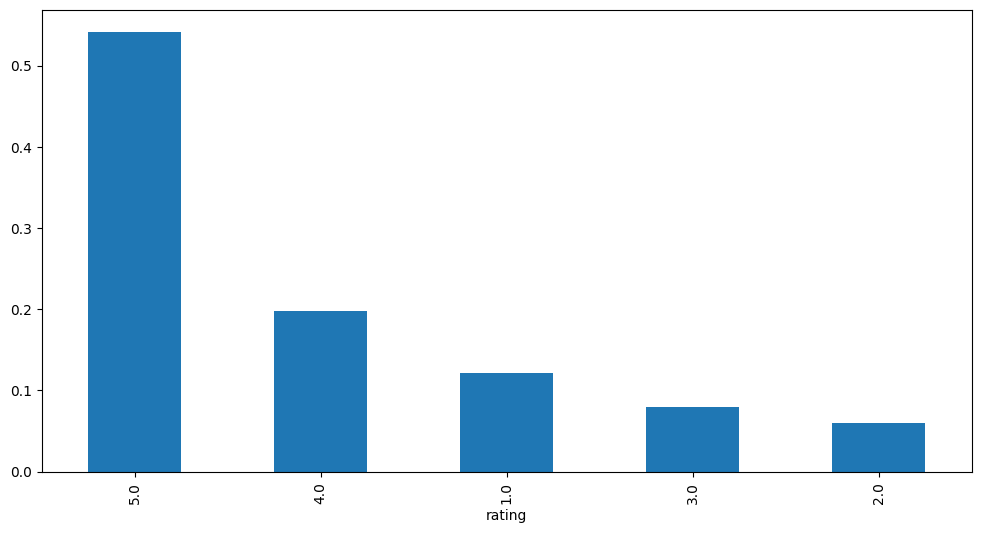

In [110]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [111]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  508402
Number of unique ITEMS in Raw data =  38908


### Users with most no of rating

In [112]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A5JLAU2ARJ0BO,357
A231WM2Z2JL0U3,249
A25HBO5V8S8SEA,162
AT6CZDCP4TRGA,99
AKT8TGIT6VVZ5,99
A6FIAB28IS79,97
A11D1KHM7DVOQK,96
A2B7BUH8834Y6M,94
A2AEZQ3DGBBLPR,79


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [113]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [114]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 2225
Number of unique USERS in the final data =  24
Number of unique PRODUCTS in the final data =  1928


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [115]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (24, 1928)
given_num_of_ratings =  2225
possible_num_of_ratings =  46272
density: 4.81%


prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0007YN3F8,B0007ZAK4O,B00080DSEM,B00080FPSY,B00080MY3I,B000816XI4,B00081A2KY,B00081A2UO,B00081GX8O,B00081NX5K
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System

In [116]:
#Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B000083JZ0,5.0,1
B00008VFCS,5.0,1
B00008VEK9,5.0,1
B00008SJX3,5.0,1
B00008SCFL,5.0,1


In [117]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

## Recommending top 5 products with 50 minimum interactions based on popularity

In [118]:
list(top_n_products(final_rating, 5, 50))

[]

## Recommending top 5 products with 100 minimum interactions based on popularity

In [119]:
list(top_n_products(final_rating, 5, 100))

[]

# Collaborative Filtering based Recommendation System

## User based collaborative filtering

In [120]:
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0007YN3F8,B0007ZAK4O,B00080DSEM,B00080FPSY,B00080MY3I,B000816XI4,B00081A2KY,B00081A2UO,B00081GX8O,B00081NX5K
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [121]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0007YN3F8,B0007ZAK4O,B00080DSEM,B00080FPSY,B00080MY3I,B000816XI4,B00081A2KY,B00081A2UO,B00081GX8O,B00081NX5K
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [122]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [123]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[6, 5, 9, 12, 17, 19, 1, 16, 8, 7]

In [124]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.06494002]]),
 array([[0.05126879]]),
 array([[0.04287882]]),
 array([[0.04203485]]),
 array([[0.03670793]]),
 array([[0.03626314]]),
 array([[0.03379159]]),
 array([[0.03063407]]),
 array([[0.02256503]]),
 array([[0.0212269]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [125]:
def similar_users(user_index, interactions_matrix):
    # ... other code ...
    try:
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
    except KeyError:
        print(f"User index {user_index} not found in the matrix.")
        # Handle the error (e.g., return an empty list, or a default value)
        return [], []
    # ... rest of the function ...

In [126]:
#Print the similarity score
similar_users(1521,final_ratings_matrix)[1][0:10]

User index 1521 not found in the matrix.


[]

### Function to recommend products

In [127]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [128]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

def similar_users(user_index, interactions_matrix):
    similarity = []
    #Iterate through all the users in the interaction matrix
    for user in interactions_matrix.index:
        #Don't calculate the similarity with the user itself
        if user == user_index:
            continue

        try:
            # Use cosine similarity to calculate the similarity between the users
            sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
            similarity.append((user, sim[0][0]))
        except KeyError:
            print(f"User index {user_index} not found in the matrix.")

    #Sort the similarity scores in descending order
    similarity.sort(key=lambda x: x[1], reverse=True)

    #Obtain the top 10 similar users
    most_similar_users = [u for u, s in similarity]
    similarity_score = [s for u, s in similarity]

    return most_similar_users, similarity_score

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [129]:
def recommendations(user_index, num_of_products, interactions_matrix):
       # ... existing code ...

       try:
           prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
       except KeyError:
           print(f"User index {user_index} not found in the matrix. Returning empty recommendations.")
           return []

       # ... rest of your existing code ...

# Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [130]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [131]:
# Singular Value Decomposition
k = min(final_ratings_sparse.shape) - 1 # ensures k is valid
U, s, Vt = svds(final_ratings_sparse, k = k) # use k to set number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [132]:
U.shape

(24, 23)

In [133]:
sigma.shape

(23, 23)

In [134]:
Vt.shape

(23, 1928)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [135]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [136]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 121

In [137]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the number of rows in the interaction matrix
    num_rows = interactions_matrix.shape[0]

    # Check if the user_index is valid
    if user_index < 0 or user_index >= num_rows:
        print(f"Invalid user index: {user_index}. The index must be between 0 and {num_rows - 1}")
        return

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

### Recommending top 10 products to user id 100

In [138]:
recommend_items(100,final_ratings_sparse,preds_matrix,10)

Invalid user index: 100. The index must be between 0 and 23


## Evaluating the model

In [139]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0007YN3F8,B0007ZAK4O,B00080DSEM,B00080FPSY,B00080MY3I,B000816XI4,B00081A2KY,B00081A2UO,B00081GX8O,B00081NX5K
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
prod_id,
1400532655,0.041667
B000000O48,0.208333
B000001OL6,0.166667
B000001OMN,0.083333
B00000J05A,0.125000


In [141]:
preds_df.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B0007YN3F8,B0007ZAK4O,B00080DSEM,B00080FPSY,B00080MY3I,B000816XI4,B00081A2KY,B00081A2UO,B00081GX8O,B00081NX5K
0,0.000029,0.000057,0.000037,1.999989,0.000114,0.001167,0.000187,0.000011,0.000037,0.999995,...,0.000086,4.999973,0.000171,0.000301,0.000700,0.000070,0.000021,0.000163,0.000207,0.000143
1,0.007276,0.014428,0.009419,0.002703,0.029114,0.297467,0.047751,0.002886,0.009419,0.001351,...,0.021828,0.006757,0.043698,0.076864,0.178480,0.017843,0.005328,0.041506,0.052678,0.036380
2,0.004069,0.008068,0.005267,0.001511,0.016281,0.166348,0.026703,0.001614,0.005267,0.000756,...,0.012207,0.003778,0.024436,0.042984,0.099809,0.009978,0.002979,0.023211,0.029458,0.020344
3,0.000223,0.000441,0.000288,0.000083,0.000890,0.009097,0.001460,0.000088,0.000288,0.000041,...,0.000668,0.000207,0.001336,0.002351,0.005458,0.000546,0.000163,0.001269,4.998389,0.001113
4,0.000342,0.000677,0.000442,0.000127,0.001367,0.013965,0.002242,0.000135,0.000442,0.000063,...,0.001025,0.000317,0.002052,0.003609,0.008379,0.000838,0.000250,0.001949,0.002473,0.001708


In [142]:
avg_preds=preds_df.mean()
avg_preds.head()

,0
prod_id,
1400532655,0.042801
B000000O48,0.210597
B000001OL6,0.168146
B000001OMN,0.083758
B00000J05A,0.129520


In [143]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
1400532655,0.041667,0.042801
B000000O48,0.208333,0.210597
B000001OL6,0.166667,0.168146
B000001OMN,0.083333,0.083758
B00000J05A,0.125000,0.129520


In [144]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.029702513682244525 

